## データの準備

In [27]:
from pandas import DataFrame
from sklearn.datasets import load_breast_cancer
from IPython.core.display import display

breast_cancer = load_breast_cancer()

X = breast_cancer.data[:,:10]
y = breast_cancer.target

columns =  ['半径', 'テクスチャ', '周囲の長さ', '面積', 'なめらかさ', 'コンパクト性', 'へこみ', 'へこみの数', '対称性', 'フラクタル次元']
df = DataFrame(data =X[:,:10], columns=columns)
df['目的変数'] = y

display(df.head())

,半径,テクスチャ,周囲の長さ,面積,なめらかさ,コンパクト性,へこみ,へこみの数,対称性,フラクタル次元,目的変数
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0


### 特徴量の選択

In [28]:
def importance(fit_data, columns, count):
    '''
    fit_dataはランダムフォレストか決定木のfit
    columnsは特徴量のラベールネーム
    countは抽出する特徴量の数かmean（平均以上）
    '''
    import numpy
    from matplotlib import pyplot
    import japanize_matplotlib

    feature_names = numpy.array(columns)
    # 特徴重要度はfeature_importance_に格納されている
    feature_importances = fit_data.feature_importances_
    # ソートするが、返す値はソート前のindex、これの通りに後から並び替えたりできる
    indices = numpy.argsort(feature_importances)

    pyplot.figure(figsize=(11, 7))
    pyplot.title('Feature Imoportances')

    # barhで横向きの棒グラフの描写設定（縦はbar）,range(len(indices)):横軸9個, feature_importances[indices]:indecesの順番でプロット
    print(range(len(indices)))
    print(feature_importances[indices])
    pyplot.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
    pyplot.yticks(range(len(indices)), feature_names[indices])
    pyplot.show()

    # 特徴量の重要度から決定領域をプロットするためのデータを決める
    print(feature_names[indices])
    if count == 'mean':
        mu = feature_importances.mean()
        top_culumns_name = feature_names[indices][::-1][feature_importances[indices][::-1] > mu]
        print(top_culumns_name)
    elif isinstance(count, int):
        # [::-1]で逆順に、[:2]で最初から二番目まで取り出し
        top_columns_name = feature_names[indices][::-1][:count]
        print(top_columns_name)
        return top_columns_name

range(0, 10)
[0.01720982 0.01891216 0.02652962 0.04372952 0.05700712 0.12412332
 0.12765945 0.1300834  0.16039278 0.29435283]


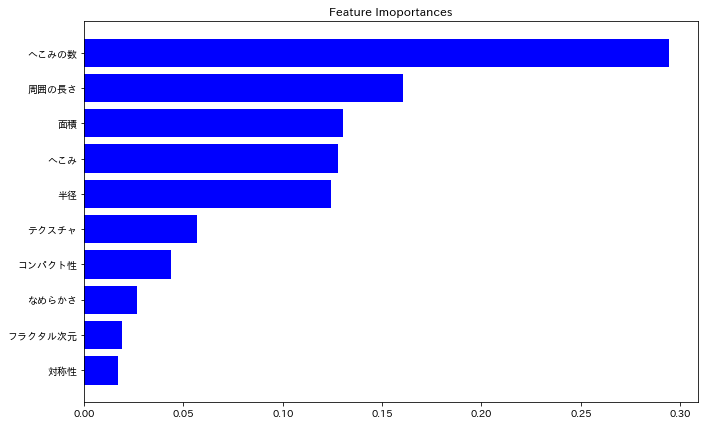

['対称性' 'フラクタル次元' 'なめらかさ' 'コンパクト性' 'テクスチャ' '半径' 'へこみ' '面積' '周囲の長さ' 'へこみの数']
['へこみの数' '周囲の長さ']


In [30]:
# ランダムフォレストにより特徴量を選択する
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=None, n_estimators=100, random_state=42)
'''
情報利得の計算にはデフォルトのジニ指数を (criterion='gini')
決定木の深さは2を (max_depth=None)、ランダムフォレストの場合弱い木を多くすることが大事
決定木の数は (n_estimators=100) を指定
'''

rf.fit(X, y)

top_columns_name = importance(rf, columns, 2)

In [36]:
X = df[top_columns_name].values
y = df['目的変数'].values

display(X.shape, y.shape)

(569, 2)

(569,)

### 学習

In [57]:
# ホールド・アウト法
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# パイプラインにより標準化してランダムフォレスト
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipelines = {
    'rf': Pipeline([('scl', StandardScaler()),
                     ('est', RandomForestClassifier(criterion='gini', max_depth=1, n_estimators=10, random_state=42))])
}

for pipe_name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)

# テストデータの予測
# テストデータを訓練データで標準化
X_test_std = pipelines['rf']['scl'].transform(X_test)
pred = pipelines['rf'].predict(X_test_std)
print(pred)

[1 0 0 1 1 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0
 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 1 0
 1 1 0 1 0 1 1 1 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 0 1 1 0 1 0 0
 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1]


### 混同行列の計算

In [60]:
# 混同行列の計算には、scikit-learn の confusion_matrix() 関数を利用
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=pred)
print(confmat)

[[57  6]
 [12 96]]


### 混同行列の可視化

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f44d85e8a20>)

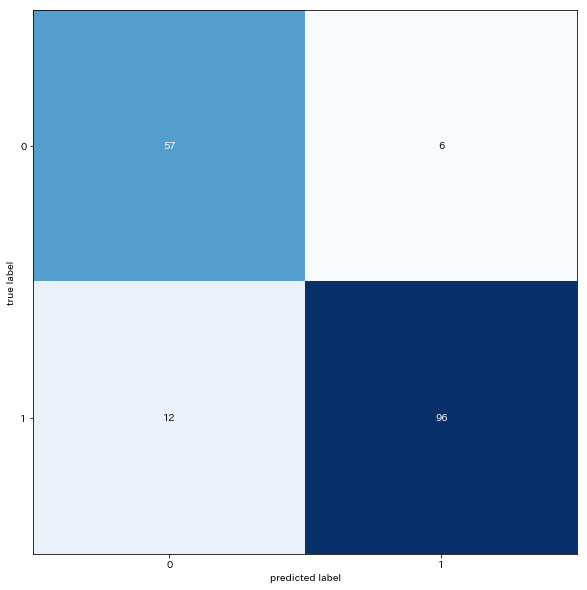

In [63]:
import numpy
from matplotlib import pyplot
import japanize_matplotlib
# mlxtend パッケージに含まれる plot_confusion_matrix() 関数を使う
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(conf_mat=confmat, figsize=(10,10))


### 正解率
- 予測サンプルの内、正解だったサンプルの割合

In [66]:
# scikit-learn の accuracy_score() 関数により、正解率の計算が出来る
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, pred))

0.8947368421052632


### 誤分類率
- 予測サンプルの内、不正解だった（予測を間違えた）サンプルの割合

In [67]:
print(1 - accuracy_score(y_test, pred))

0.10526315789473684


### 適合率
- 陽性クラスと予測されたサンプルの内、実際に陽性クラスだったサンプルの割合

In [69]:
# scikit-learn の precision_score() 関数により、適合率の計算ができる
from sklearn.metrics import precision_score

print(precision_score(y_test, pred))

0.9411764705882353


### 再現率
- 正解ラベルが陽性であるサンプルの内、予測サンプルが陽性であったサンプルの割合

In [71]:
# scikit-learn の recall_score() 関数により、再現率の計算ができる
from sklearn.metrics import recall_score

print(recall_score(y_test, pred))

0.8888888888888888


### F1スコア
- 適合率と再現率を組み合わせた尺度で、これらの調和平均を計算する

In [74]:
# scikit-learn の f1_score() 関数により、F1スコアの計算ができる
from sklearn.metrics import f1_score

print(f1_score(y_test, pred))

0.9142857142857143


### 偽陽性率
- 正解ラベルが陰性であるサンプルの内、予測サンプルが陽性であったサンプルの割合

In [79]:
# scikit-learn の roc_curve() 関数により、roc曲線を算出する際にfprの計算ができる
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, pred)
print(fpr)

[0.        0.0952381 1.       ]


### ROC曲線
- x軸に偽陽性率(FPR)を、y軸に真陽性率(=再現率)をプロットする。

### AUC
- ROCカーブの下の領域の面積。area under the curveの略。1に近いほどよい。

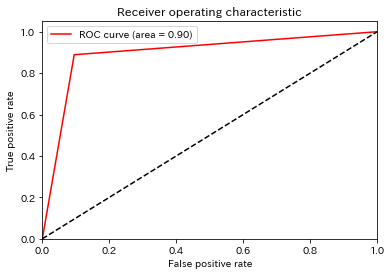

In [91]:
# scikit-learn の auc() 関数によりaucの計算ができる
from sklearn.metrics import auc
# AUCの算出
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

# ROC曲線の描画
pyplot.plot(fpr, tpr, color='red', label='ROC curve (area = %.2f)' % roc_auc)
pyplot.plot([0, 1], [0, 1], color='black', linestyle='--')

pyplot.xlim([0.0, 1.0])
pyplot.ylim([0.0, 1.05])
pyplot.xlabel('False positive rate')
pyplot.ylabel('True positive rate')
pyplot.title('Receiver operating characteristic')
pyplot.legend(loc="best")